### 1. 들어가며
- augmentation + 텐서플로우 모델 학습에 어떻게 적용할 수 있는지  
  Augmentation도 입력 이미지의 데이터를 변경해 주는 과정이라  
  이미지 데이터 전처리 방법과 활용방법 동일  


##### 1) 필요한 라이브러리 import

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
#학습 전, GPU 환경 확인 (필수)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##### 2) 데이터 셋 불러오기  
- [stanford_dogs 데이터셋](https://www.tensorflow.org/datasets/catalog/stanford_dogs)  
  120개 견종의 이미지 포함  
  총 20,580장 (12,000장 학습셋, 8,580장은 평가용 셋)  
  
  
- 프로젝트 디렉토리말고,TensorFlow Datasets 기본 디렉토리에 저장하기  
  (데이터셋은 다른 프로젝트에서도 사용할 수 있으니)

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보 확인 필수 
print(ds_info.features)

#채널 수 : 3

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


In [5]:
# 데이터 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


In [6]:
#클래스 개수
ds_info.features["label"].num_classes

120

In [7]:
#클래스 명
ds_info.features["label"].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

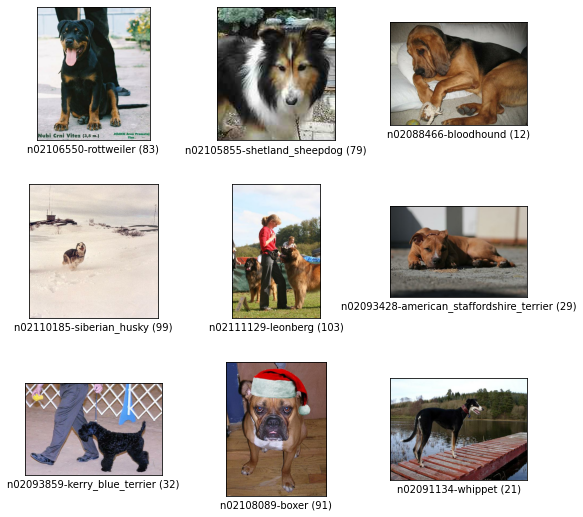

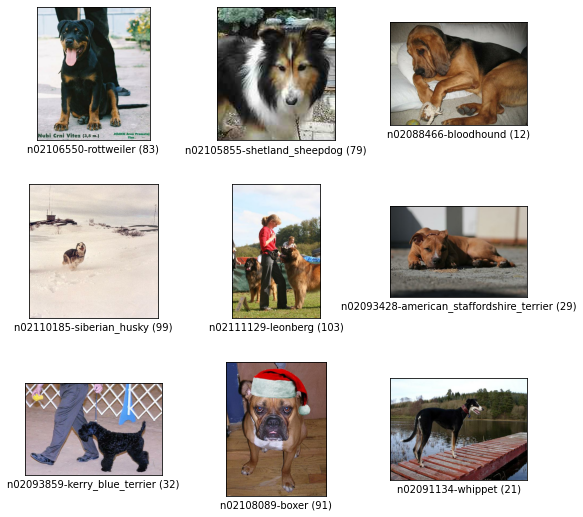

In [8]:
#다운로드 받은 데이터 확인
tfds.show_examples(ds_train, ds_info)

-----
### 2. Augmentation 적용하기  

#### 1. 텐서플로우 Random Augmentation API 사용하기  
- 텐서플로우 API로 바로 사용할 수 있는 방법들을 먼저 적용해보기로 함  
- 이미지셋에 대해서 랜덤한 확률로 바로 적용할 수 있는 augmentation 함수  
  1) random_brightness()  
  2) random_contrast()  
  3) random_crop()  
  4) random_flip_left_right()  
  5) random_flip_up_down()  
  6) random_hue()  
  7) random_jpeg_quality()  
  8) random_saturation()  
 
##### 1) 기본적인 전처리 함수 생성  
- Augmentation 적용 전  
- 이미지 변환의 결과로 리턴 받은 이미지 그 다음 전처리 함수 입력으로  
  계속 재사용할 수 있는 구조가 됨 -> 편리  
  
  
```
def 전처리_함수(image, label):   # 변환할 이미지와 라벨
    # 이미지 변환 로직 적용
    new_image = 이미지_변환(image)
    return new_image, label  
```
- 입력받은 이미지를 0~1 사이의 float32로 normalize  
- (224, 224) 사이즈로 resize  

In [9]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

##### 2) random augmentation 중 몇몇 기능 적용  
- andom_flip_left_right() :  
  좌우 대칭 해줌  
  -> 개 이미지에서 좌우 대칭 해도 괜찮음  
  (근데 만약 글자였다면? 주의해야할 듯)  
  -> 상하대칭은 안할게  
  (데이터 셋 생각 해볼 때, 위아래 뒤집힌 사진 없어서 도움 안될듯)  
  
  
- random_brightness() :  
  밝기 조절해서 다양한 환경에서 얻어진 이미지에 대응할 수 있도록 의도  
  

In [10]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

##### 3) Augmentation 적용 함수 생성  
- apply_normalize_on_dataset() :  
  원본 데이터셋에 다양한 형태의 가공한 형태의  
  새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수  
  
  -> 일반적인 전처리 과정  
  (normalize, resize, augmentation, shuffle 적용)  
  
  -> 주의해야 할 점  
  shuffle이나 augmentation은 테스트 데이터셋에는 적용 안함  
  
  
- 여러결과 조합 위한 앙상블(ensemble) 방법 중 하나  
  -> 테스트 데이터셋에 augmentation 적용하는 test-time augmentation  
  (캐글 등 경쟁 머신러닝에 많이 사용, 지금은 개념만 알아두자)  
  ([ test-time augmentation 설명 블로그](https://hwiyong.tistory.com/215))  
  
  
- with_aug=False :  
  augmentation의 적용여부를 결정할 수 있도록 함  
  (이후 비교 실험 위해)  
  [tf.data.Datasets.map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)  

In [11]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2 #병렬 처리 수준 지정
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

#### 2. Random Augmentation 직접 구현하기  
- 위에서 만든 augment() :  
  미리 구현된 random augmentation을 적용하는 함수  
  
- augment2() :  
  tf.image의 다양한 함수들로 직접 다양한 augmentation 기법을 랜덤하게  
  적용해보는 함수 생성해보기  

In [12]:
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

-----
### 3. 비교실험 하기  
- 비교할 것  
  augmentation 적용 vs 적용하지 않은 데이터  
  학습시킨 모델의 성능  
  -> 새로운 augmentation 하고 싶으면 그것도 비교 가능  
  
##### 1) 기본:  ResNet50 중 imagenet 으로 훈련된 모델 불러오기

In [13]:
#num_classes = 데이터셋의 라벨 개수 받아옴
num_classes = ds_info.features["label"].num_classes

#텐서플로우 케라스의 ResNet50 중 imagenet으로 훈련된 모델 불러옴
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # include_top: 마지막 fully connected layer 포함/미포함
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


94773248/94765736 [==============================] - 2s 0us/step


- include_top 으로 마지막 fully connected layer 미포함시키면  
  -> 특성 추출기(feature extractor) 부분만 불러옴  
  -> 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용 가능  
  -> 왜 이렇게 할까?  
  -> 이미지넷(ImageNet)과 우리의 테스트셋 서로 다른 클래스 가지기 때문  
  -> 그래서 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수)또한 다르기 때문  

##### 2) Augmentation 적용:  ResNet 하나 더 생성  
-  질문 : 왜 굳이 모델을 하나 더 만들지?  
   그냥 같은 모델이면 데이터셋만 aug 적용해서 학습하면 되지 않나?  
   -> 다른 하이퍼파라미터 적용 등 다른 실험 상황들에 쓰기 위해  

In [14]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

##### 3) Augmentation 적용 vs 미적용  데이터셋 구성
볼러온 데이터에  
apply_normalize_on_dataset() 내에  
1) with_aug= False  
   -> augmentation이 적용되지 않도록  

2) with_aug= True  
   -> augmentation 적용

3) 그리고 aug 적용 안한 test 데이터 셋으로 데이터셋 구성  

In [15]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

##### 4) 학습  
- 아래에서 한꺼번에 진행  
- EPOCH=20으로 진행시 GPU 기반으로 3~4시간 가량의 시간이 소요  
- 예시로 3만 돌려봄  
  실제에서는 충분한 학습이 꼭 진행되어야함  

##### 5) 훈련과정 시각화
- 아래에서 한꺼번에 진행  

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

- 좀 더 확대해서 시각화 해보기

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

- EPOCH=20으로 수행해 본 두 모델의 훈련 과정 시각화 결과 (미리보기)    
  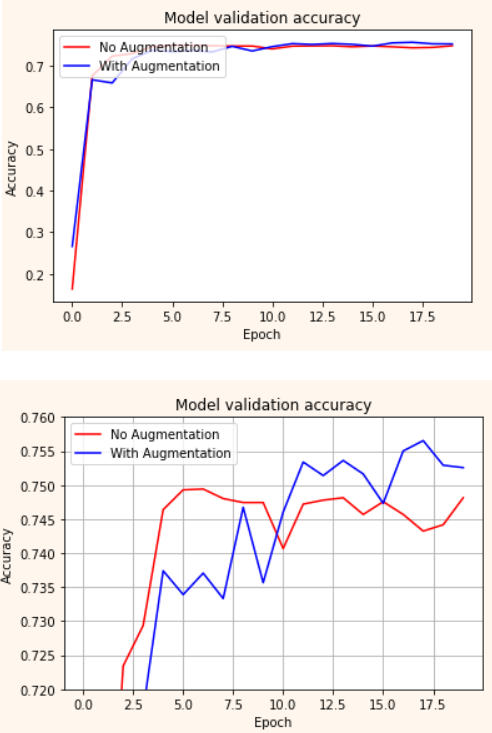  
   -> Augmentation 적용한 학습이 더 천천히 학습되지만  
   EPOCH 10을 전후해서 aug_resnet50의 accuracy가 더 높게 형성

-----
### 5. Cutmix Augmentation  

#### 1. 개념  
##### 1) 소개  
네이버 클로바(CLOVA)에서 발표한  
[CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/pdf/1905.04899.pdf) 에서 제안된 방법  
-> 이미지를 자르고 섞는 것  
  
  
##### 2) ResNet-50 vs Mixup vs Cutout
  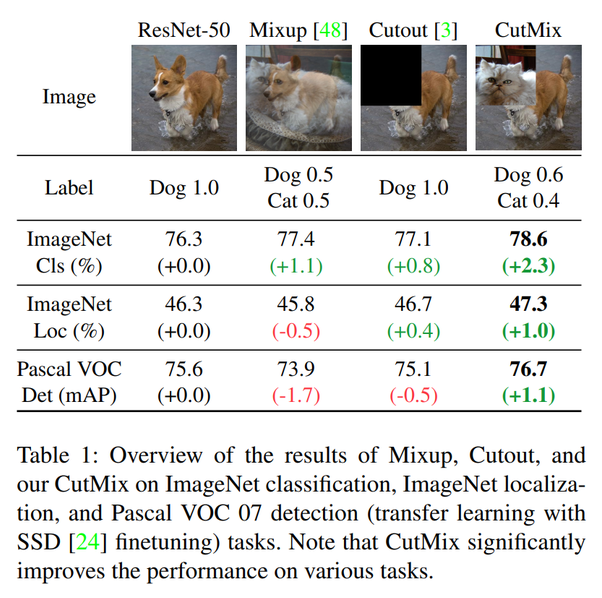  
  1) ResNet-50 : 일반적으로 우리가 사용해왔던 방식  
  2) Mixup : 특정 비율로 픽셀별 값을 섞는 방식  
  3) Cutout : 이미지를 잘라내는 방식  
  (CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법)  
  

##### 3)  캐글 참고  
[Chris Deotte's CutMix and MixUp on GPU/TPU](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu)  
-> 캐글 그랜드마스터인 Chris Deotte가 구현한 CutMix와 MixUp 확인 가능
-> 구현 시 참고해보기  
(캐글에서 비슷한 태스크 대회 있는 경우,  
다른 사람이 적용한 방법 보는 것도 인사이트 얻기에 좋음)  

#### 2. 이미지 섞기  
- 두 이미지 섞는 것 부터 생각해보자  
  -> 배치 내 이미지 2개 골라서 섞음  
  -> 이때 이미지에서 잘라서 섞어 주는 영역 = 바운딩 박스(bounding box)  

##### 1) 데이터 셋에서 임의의 이미지 2개 가져오기

랜덤한 바운딩 박스 위치 추출 + 두 이미지 섞는 함수 생성  
- 이미지를 텐서로 만들어 텐서플로우 연산  
  <- 예시로 이미지 2개 가져와서 실행  
  <- 이미지는 tfds에서 한 장 뽑아서 사용  

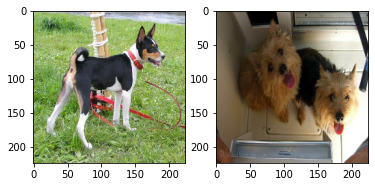

In [16]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
# result = object.take(indices, axis=1) 
# object = 메서드가 적용되는 객체 = DataFrame, Series
# indices : 인덱스
# axis = 0 : 행 인덱스 정렬, axis = 1 : 열 인덱스 정렬

#enumerate() : (인덱스,원소) 튜플로 가져오는데, 여기선 (인덱스,(image, label))
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    #16 배치 사이즈를 했으니까 -> 750개가 16개로 나뉘어서 10개의 그룹이 있는거
    # 행 : 750개, 열 : 16개
    # 0 인덱스라면 라벨이랑 이미지를 변수에 할당할건데
    # 여기서 0 인덱스는 
    #클래스가 개 하나라서 인덱스 0 에 모든 개의 사진이 있는건가?
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

##### 2) 바운딩 박스의 위치를 결정하는 함수 생성  
- 바탕 : a 이미지  
  삽입 : b 이미지  
  ->  a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수 생성  
  
  
- 이미지 a, b가 모두 (224, 224)로 resize 되어 있음  
  ->두 이미지의 width, height가 같은 경우로 가정됨  
  ->그러나 예외가 있을 수 있음  
  ->CutMix 공식 repo 에선 width, height가 달라도  
  가변적으로 적용할 수 있도록 구현 되어있음  
  
  
- 우리도 임의의 이미지 사이즈에 대해서도  
  유연하게 대응 가능하도록 함수 생성  

In [17]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1] # W = 가로길이
    image_size_y = image_a.shape[0] # H = 세로길이
    
    # get center of box
      #random.uniform() : 랜덤 모듈 내 정의 되어있는 두 수 사이 랜덤한 소수를 리턴해주는 함수
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(156, shape=(), dtype=int32)
y :  tf.Tensor(109, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


##### 3) 이미지 합치는 함수  
- 바탕이미지 image_a의 바운딩 박스 바깥 영역  
  +다른 이미지 image_b 바운딩 박스 안쪽 영역  

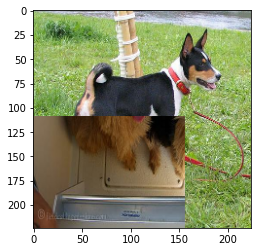

In [18]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

#### 3. 라벨 섞기  
- 이미지를 섞었다면  
  라벨도 맞춰서 섞어줘야함  
  -> 이미지 섞은 비율에 맞춰서 라벨도 섞기  
  -> CutMix에서는 면적에 비례해서 라벨 섞음  
  -> 이때 라벨 벡터는 보통 클래스 표시되듯이  
  class 1개에 1의 값 가져지는 원-핫 인코딩 방식이 아님  
  -> A와 B 클래스에 해당하는 인덱스에 각 각 0.4, 0.6 과 같은 값이  
  배분되는 방식이 사용됨  
  
##### 1) 이미지 섞인 라벨 만들 때 적절한 비율로 라벨 함쳐주는 함수 생성  

In [19]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.35754144, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

##### 2) 최종적인 cutmix() 함수 생성  
- 위에서 구현한  
  mix_2_images() : 이미지 섞기  
  mix_2_label() : 라벨 섞기  
  함수 활용해서 배치단위 함수 생성

In [20]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


-----
### 6. Mixup Augmentation  
- [mixup:Beyond Empirical Risk Minimization 논문](https://arxiv.org/abs/1710.09412)  
  

#### 1. 함수 생성
- 두 이미지 쌍을 섞을 비율  
  -> 일정한 범위 내 랜덤하게 뽑음  
  -> 비율에 따라 두 이미지 픽셀별 값, 라벨 섞어주기  
  
  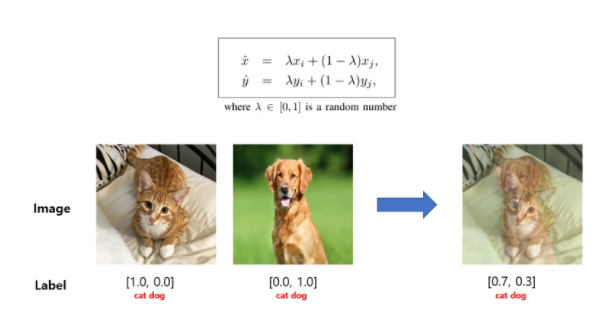  
  
##### 1) 랜덤한 비율로 두 이미지 mixup 함수 생성  

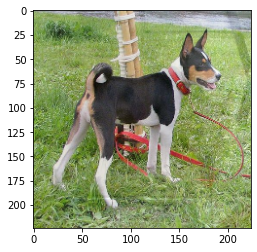

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.18113315
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0. 

In [21]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

##### 2) 배치 단위의 mixup() 함수 생성  

In [22]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

-----
### 5. Agumentation 적용 최종 메인 함수 생성

 
- apply_normalize_on_dataset() :  
  원본 데이터셋에 다양한 형태의 가공한 형태의  
  새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수  
  
  -> 일반적인 전처리 과정  
  (normalize, resize, augmentation, shuffle 적용)  
  
  -> 주의해야 할 점  
  shuffle이나 augmentation은 테스트 데이터셋에는 적용 안함  
  
  
- 여러결과 조합 위한 앙상블(ensemble) 방법 중 하나  
  -> 테스트 데이터셋에 augmentation 적용하는 test-time augmentation  
  (캐글 등 경쟁 머신러닝에 많이 사용, 지금은 개념만 알아두자)  
  ([ test-time augmentation 설명 블로그](https://hwiyong.tistory.com/215))  
  
  
- with_aug=False :  
  augmentation의 적용여부를 결정할 수 있도록 함  
  (이후 비교 실험 위해)  
  [tf.data.Datasets.map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)  

In [23]:
BATCH_SIZE = 20

In [24]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=BATCH_SIZE, with_aug=False, with_cutmix=False,with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 7. 데이터셋 구성하기  
- 각각의 Augumentation이 적용/미적용 된 데이터셋 구성

In [25]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

### 6. 비교 실험하기  
- 비교하려고 하는 것  
  1) Augumentation 미적용  
  2) 기본 Augumentation 적용  
  3) Augumentation Cutmix 적용  
  4) Augumentation Cutmix + 기본 Augumentation 적용  
  5) Augumentation Mixup 적용  
  6) Augumentation Mixup  + 기본 Augumentation 적용  
  데이터들 학습시켜서 성능 비교  

#### 1. 데이터셋 구성  
- 총 6개의 데이터 셋 구성  

In [26]:
(ds_train,ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train','test'],
    as_supervised = True,
    shuffle_files = True,
    with_info = True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train,with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train,with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train,batch_size=BATCH_SIZE,with_cutmix=True)
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train,batch_size=BATCH_SIZE,with_aug=True,with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train,batch_size=BATCH_SIZE,with_mixup=True)
ds_train_mixup_aug = apply_normalize_on_dataset(ds_train,batch_size=BATCH_SIZE,with_aug=True,with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test,is_test=True)

#### 2. 모델 생성  
##### 1) 기본:  ResNet50 중 imagenet 으로 훈련된 모델 불러오기  
- Augumentation 미적용  

In [27]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

##### 2) 기본 Augumentation + ResNet50   
- 기본 Augumentation 적용


In [28]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

##### 3)  Cutmix + ResNet50  
- 3) Augumentation Cutmix 만 적용

In [29]:
cut_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

##### 4) 기본 Augumentation +  Cutmix + ResNet50 
4) Augumentation Cutmix + 기본 Augumentation 적용

In [30]:
cut_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

##### 5) Mixup+ ResNet50 
- Augumentation Mixup 만 적용

In [31]:
mix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

##### 6) 기본 Augumentation + Mixup+ ResNet50 
- Augumentation Mixup + 기본 Augumentation 적용

In [32]:
mix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

#### 3. 모델 학습  

In [33]:
# 1. ResNet 50 (기본)
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# 2. 기본 Augumentation 적용
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# 3. cut 만 적용
cut_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# 4. 기본 aug + cut 적용
cut_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# 5. mix 만 적용
mix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# 6. 기본 aug + mix 적용
mix_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [34]:
#warning 무시 코드  
#터미널에 export TF_CPP_MIN_LOG_LEVEL=2 이후
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [35]:
EPOCH = 20

# 1. ResNet 50 (기본)------------------------------
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

#테스트 데이터셋 나눠서 학습돌리기

Epoch 1/20
750/750 [==============================] - 461s 567ms/step - loss: 3.0487 - accuracy: 0.3084 - val_loss: 3.3703 - val_accuracy: 0.2106
Epoch 2/20
750/750 [==============================] - 357s 476ms/step - loss: 0.7145 - accuracy: 0.8025
Epoch 3/20
750/750 [==============================] - 358s 477ms/step - loss: 0.2155 - accuracy: 0.9564
Epoch 4/20
750/750 [==============================] - 358s 477ms/step - loss: 0.0768 - accuracy: 0.9932
Epoch 5/20
750/750 [==============================] - 358s 478ms/step - loss: 0.0323 - accuracy: 0.9983
Epoch 6/20
750/750 [==============================] - 357s 477ms/step - loss: 0.0173 - accuracy: 0.9991
Epoch 7/20
750/750 [==============================] - 357s 476ms/step - loss: 0.0162 - accuracy: 0.9994
Epoch 8/20
750/750 [==============================] - 358s 477ms/step - loss: 0.0135 - accuracy: 0.9994
Epoch 9/20
750/750 [==============================] - 359s 478ms/step - loss: 0.0110 - accuracy: 0.9995
Epoch 10/20
750/750 [=

In [36]:
# 2. 기본 Augumentation 적용-------------------------
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
750/750 [==============================] - 435s 567ms/step - loss: 3.1096 - accuracy: 0.3010 - val_loss: 2.8772 - val_accuracy: 0.2825
Epoch 2/20
750/750 [==============================] - 356s 475ms/step - loss: 0.9488 - accuracy: 0.7259
Epoch 3/20
750/750 [==============================] - 357s 476ms/step - loss: 0.4834 - accuracy: 0.8663
Epoch 4/20
750/750 [==============================] - 358s 477ms/step - loss: 0.2490 - accuracy: 0.9394
Epoch 5/20
750/750 [==============================] - 358s 477ms/step - loss: 0.1647 - accuracy: 0.9645
Epoch 6/20
750/750 [==============================] - 358s 477ms/step - loss: 0.0880 - accuracy: 0.9860
Epoch 7/20
750/750 [==============================] - 357s 476ms/step - loss: 0.0571 - accuracy: 0.9932
Epoch 8/20
750/750 [==============================] - 358s 477ms/step - loss: 0.0383 - accuracy: 0.9952
Epoch 9/20
750/750 [==============================] - 357s 476ms/step - loss: 0.0326 - accuracy: 0.9953
Epoch 10/20
750/750 [=

In [38]:
# 3. cut 만 적용---------------------------------
history_resnet50_cut = aug_resnet50.fit(
    ds_train_cutmix, # cut 만 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 403s 459ms/step - loss: 2.4367 - accuracy: 0.6238 - val_loss: 1.3952 - val_accuracy: 0.6324
Epoch 2/20
750/750 [==============================] - 278s 370ms/step - loss: 2.2413 - accuracy: 0.6779
Epoch 3/20
750/750 [==============================] - 277s 369ms/step - loss: 2.1125 - accuracy: 0.7069
Epoch 4/20
750/750 [==============================] - 277s 369ms/step - loss: 1.9977 - accuracy: 0.7408
Epoch 5/20
750/750 [==============================] - 277s 370ms/step - loss: 1.9781 - accuracy: 0.7479
Epoch 6/20
750/750 [==============================] - 278s 371ms/step - loss: 1.9288 - accuracy: 0.7517
Epoch 7/20
750/750 [==============================] - 277s 369ms/step - loss: 1.8479 - accuracy: 0.7719
Epoch 8/20
750/750 [==============================] - 277s 369ms/step - loss: 1.8312 - accuracy: 0.7769
Epoch 9/20
750/750 [==============================] - 277s 369ms/step - loss: 1.7804 - accuracy: 0.7878
Epoch 10/20
750/750 [=

In [39]:
# 4. 기본 aug + cut 적용-------------------------
history_resnet50_cut_aug = aug_resnet50.fit(
    ds_train_cutmix_aug, # cut +augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
750/750 [==============================] - 351s 460ms/step - loss: 1.7593 - accuracy: 0.7601 - val_loss: 1.3569 - val_accuracy: 0.6717
Epoch 2/20
750/750 [==============================] - 276s 369ms/step - loss: 1.6983 - accuracy: 0.7838
Epoch 3/20
750/750 [==============================] - 277s 369ms/step - loss: 1.6944 - accuracy: 0.7769
Epoch 4/20
750/750 [==============================] - 277s 370ms/step - loss: 1.6625 - accuracy: 0.7833
Epoch 5/20
750/750 [==============================] - 277s 369ms/step - loss: 1.6442 - accuracy: 0.7875
Epoch 6/20
750/750 [==============================] - 277s 369ms/step - loss: 1.6064 - accuracy: 0.8052
Epoch 7/20
750/750 [==============================] - 277s 369ms/step - loss: 1.6032 - accuracy: 0.7964
Epoch 8/20
750/750 [==============================] - 277s 369ms/step - loss: 1.5748 - accuracy: 0.8067
Epoch 9/20
750/750 [==============================] - 277s 369ms/step - loss: 1.5700 - accuracy: 0.8065
Epoch 10/20
750/750 [=

In [40]:
# 5. mix 만 적용---------------------------------
history_resnet50_mix = aug_resnet50.fit(
    ds_train_mixup, # mix만 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
750/750 [==============================] - 350s 460ms/step - loss: 1.8072 - accuracy: 0.8546 - val_loss: 1.6909 - val_accuracy: 0.6298
Epoch 2/20
750/750 [==============================] - 278s 370ms/step - loss: 1.7530 - accuracy: 0.8584
Epoch 3/20
750/750 [==============================] - 277s 369ms/step - loss: 1.7186 - accuracy: 0.8576
Epoch 4/20
750/750 [==============================] - 277s 369ms/step - loss: 1.6918 - accuracy: 0.8682
Epoch 5/20
750/750 [==============================] - 278s 371ms/step - loss: 1.6850 - accuracy: 0.8618
Epoch 6/20
750/750 [==============================] - 277s 369ms/step - loss: 1.6605 - accuracy: 0.8723
Epoch 7/20
750/750 [==============================] - 276s 369ms/step - loss: 1.6467 - accuracy: 0.8734
Epoch 8/20
750/750 [==============================] - 276s 369ms/step - loss: 1.6290 - accuracy: 0.8784
Epoch 9/20
750/750 [==============================] - 277s 369ms/step - loss: 1.6168 - accuracy: 0.8771
Epoch 10/20
750/750 [=

In [41]:
# 6. 기본 aug + mix 적용-------------------------
history_resnet50_mix_aug = aug_resnet50.fit(
    ds_train_mixup_aug, # mix + augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)



Epoch 1/20
750/750 [==============================] - 353s 463ms/step - loss: 1.6477 - accuracy: 0.8553 - val_loss: 1.3446 - val_accuracy: 0.6904
Epoch 2/20
750/750 [==============================] - 277s 370ms/step - loss: 1.6302 - accuracy: 0.8618
Epoch 3/20
750/750 [==============================] - 276s 368ms/step - loss: 1.6135 - accuracy: 0.8572
Epoch 4/20
750/750 [==============================] - 276s 368ms/step - loss: 1.6141 - accuracy: 0.8597
Epoch 5/20
750/750 [==============================] - 276s 367ms/step - loss: 1.6006 - accuracy: 0.8668
Epoch 6/20
750/750 [==============================] - 276s 368ms/step - loss: 1.5907 - accuracy: 0.8659
Epoch 7/20
750/750 [==============================] - 276s 368ms/step - loss: 1.5763 - accuracy: 0.8714
Epoch 8/20
750/750 [==============================] - 276s 368ms/step - loss: 1.5557 - accuracy: 0.8749
Epoch 9/20
750/750 [==============================] - 276s 368ms/step - loss: 1.5510 - accuracy: 0.8737
Epoch 10/20
750/750 [=

- 모델 훈련시   
  위에서 만든 CutMix나 Mixup을 사용하기 위해  
  앞에서 resnet50과 aug_resnet50을 훈련하는 데  
  
1) categorical_crossentropy()  
  ```
  def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label
  ```
원-핫 인코딩으로 image,label 를 변환해서 사용  
- categorical_crossentropy() 란?  
  - Multi-class classification 즉 클래스가 여러 개인 다중 분류 문제에서 사용  
  - label이 원-핫 인코딩 된 형태 즉 label이 class를 나타내는 one-hot vector를 값으로 가질 때 사용  
  - 예를 들어, 3-class classification 문제에서  
    label이 [1, 0, 0] 또는 [0, 1, 0] 또는 [0, 0, 1]을 값으로 가질 때 사용  
  - 모델의 마지막 레이어의 활성화 함수는 소프트맥스 함수    
  
  
  2) sparse_categorical_crossentropy()은  
    저 원핫 인코딩을 안해주면 사용 가능  
  
  - sparse_categorical_crossentropy 이란? 
    - categorical_crossentropy와 동일한 다중 분류 손실함수  
    - integer type 클래스라는 것이 다름  
    - 출력 실측값이 [0, 1, 2] 와 같은 형태로 one-hot encoding 과정을 하지 않아도 됨  
    - 실측 출력값을 입력하는 부분에서 별도로 one-hot encoding을 할 필요가 없이 정수값 그대로 주고,  
      손실함수를  sparse_categorical_crossentropy 로 바꿔주기만 하면 됨  
      
[categorical_crossentropy, sparse_categorical_crossentropy() 설명 블로그](https://crazyj.tistory.com/153)   

#### 4. 훈련 결과 시각화  

- accuracy

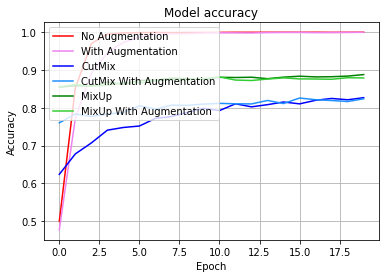

In [66]:
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'violet')
plt.plot(history_resnet50_cut.history['accuracy'], 'b')
plt.plot(history_resnet50_cut_aug.history['accuracy'], 'dodgerblue')
plt.plot(history_resnet50_mix.history['accuracy'], 'g')
plt.plot(history_resnet50_mix_aug.history['accuracy'], 'limegreen')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['No Augmentation', 'With Augmentation','CutMix',
           'CutMix With Augmentation','MixUp','MixUp With Augmentation'],loc='upper left')
plt.show()

- loss

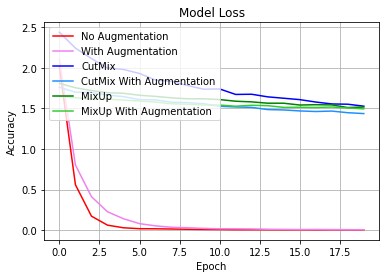

In [65]:
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'violet')
plt.plot(history_resnet50_cut.history['loss'], 'b')
plt.plot(history_resnet50_cut_aug.history['loss'], 'dodgerblue')
plt.plot(history_resnet50_mix.history['loss'], 'g')
plt.plot(history_resnet50_mix_aug.history['loss'], 'limegreen')

plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','CutMix',
           'CutMix With Augmentation','MixUp','MixUp With Augmentation'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

- val 에 대한 시각화가 진행되지 못해서, 아쉬운 시각화지만  
  많은 augmentation 기법을 적용하지 않거나 가볍게 적용한 모델이  
  학습 결과가 더 좋아보인다  


- 많은 aug기법 적용한 모델이  
  더 다양한 문제를 학습시켰기 때문에 학습해야할 상황들이 더 많아져서  
  aug를 적용하지 않은 모델보다 더 안좋은 accuracy, loss를 갖는것인지  
  원인이 분명하게 도출되지 못했다  
  
  
- 동료들의 val 시각화 결과를 본다면  
  aug를 미적용하거나 가볍게 적용했을 때는 일정 수준이 되면 loss가 낮아지지 않는 것 같다  
  더 오래 학습을 시켰을때 미적용, 기본 적용은 일정 수준 loss값 이후엔 오버피팅이 되지만,  
  aug를 적용한 모델들은 미적용,기본적용을 한 모델들에 비해  
  더 낮은 loss값 도출과 오버피팅이 방지되지 않을까? 라는 조심스런 추론을 해본다  
  
  
  
 

-----
## 회고  

### 💚루브릭 평가  
1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?  
CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴함  


2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?  
Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함  


3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?  
기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석함    


### 💚 개선점 & 의문점  
##### 1) aug, cutmix 모두 반영  
cutmix함수에 기존 aug 함수 내용 넣었는데  
오류없이 작동되었지만  
정상적으로 데이터가 aug반영 된건지 확신이 안든다  
퍼실님께 피드백 받기로 ...!
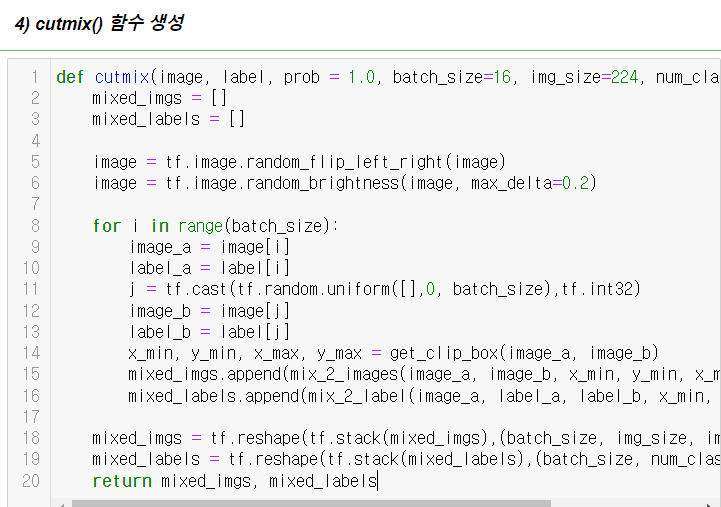  

##### 2) 데이터 적용 최종 함수 각각 생성  
처음엔 기능마다 함수 생성하려고 했더니 에러가 났다  
왜그런지 이유를 혼자 밝혀내지 못했다  
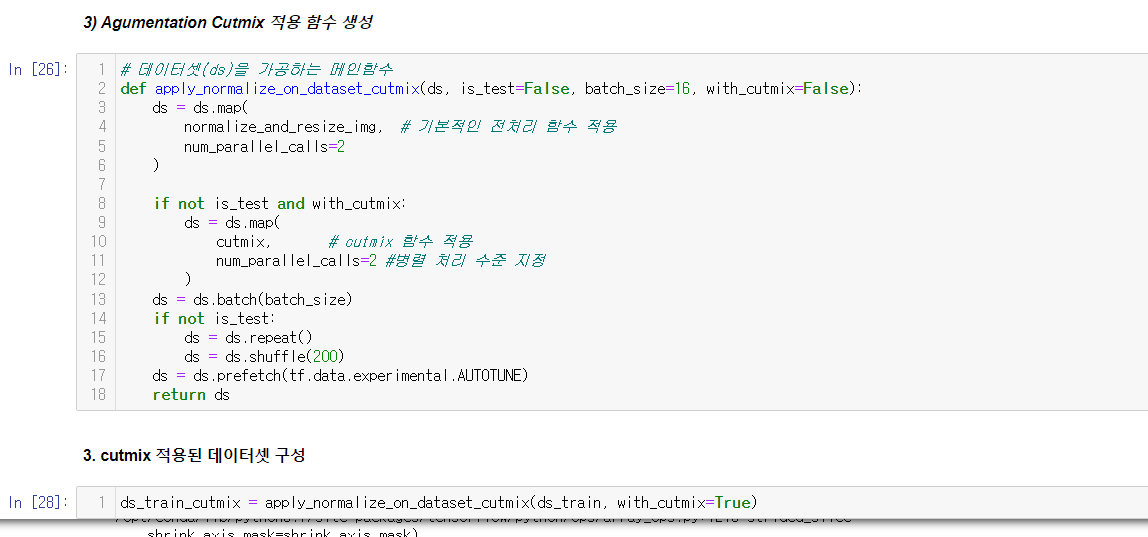  

##### 3) val_accuracy 
학습시 val_accuracy 가 나오지 않는다  
다른 동료들과 동일하게 진행 흐름을 가지고 있는데도 불구하고 1 epoch만 진행된다  
1 epoch에서 진행되는것을 보면, test 데이터 셋도 잘 분리된 것 같은데  
1 epoch 이후에는 test(val)이 진행되고 있지 않은것인가 의문이 든다  
미해결 과제이고, 복습 시에 해결해봐야할 부분  


### 💚 참고 자료
1. [categorical_crossentropy, sparse_categorical_crossentropy() 설명 블로그](https://crazyj.tistory.com/153)   
2. [ test-time augmentation 설명 블로그](https://hwiyong.tistory.com/215)  
3. [tf.data.Datasets.map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)  